# Dimensionality reduction

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


## Loading data and model

In [2]:
mouse_id = 'Mouse24'
session_id = '131213'
phase = 'wake'
subset = 'nonhdc'

bin_size = 160  # ms

# data
single_spikes = False
dataset_hdc = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size,
                               single_spikes, path='/scratches/ramanujan_2/dl543/HDC_PartIII/')

dataset_nonhdc = HDC.get_dataset(mouse_id, session_id, phase, 'nonhdc', 
                                 bin_size, single_spikes, 
                                 path='/scratches/ramanujan_2/dl543/HDC_PartIII/')

units:  28  hdc units:  5
units:  28  hdc units:  5


In [3]:
bin_size = 160  # ms

model_dict_hdc = {
    'seed': 123,
    'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
    'filt_mode': '',  # GLM couplings
    'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
    'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
    'z_mode': '',  # latent covariates
    'hist_len': 0,
    'folds': 5,
    'delays': [0],
    'neurons': dataset_hdc['neurons'],
    'max_count': dataset_hdc['max_count'],
    'bin_size': dataset_hdc['bin_size'],
    'tbin': dataset_hdc['tbin'],
    'model_name': dataset_hdc['name'],
    'tensor_type': torch.float,
    'jitter': 1e-5,
}

model_dict_nonhdc = {
    'seed': 123,
    'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
    'filt_mode': '',  # GLM couplings
    'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
    'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
    'z_mode': '',  # latent covariates
    'hist_len': 0,
    'folds': 5,
    'delays': [0],
    'neurons': dataset_nonhdc['neurons'],
    'max_count': dataset_nonhdc['max_count'],
    'bin_size': dataset_nonhdc['bin_size'],
    'tbin': dataset_nonhdc['tbin'],
    'model_name': dataset_nonhdc['name'],
    'tensor_type': torch.float,
    'jitter': 1e-5,
}

checkpoint_dir = '/scratches/ramanujan_2/dl543/HDC_PartIII/checkpoint/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below

# model and train/test split based on which validation fold is given by cv_run
modelfit_hdc, training_results_hdc, fit_set_hdc, validation_set_hdc = lib.models.load_model(
    checkpoint_dir, model_dict_hdc, dataset_hdc, HDC.enc_used,
    delay, cv_run, batch_size, gpu_dev
)

modelfit_nonhdc, training_results_nonhdc, fit_set_nonhdc, validation_set_nonhdc = lib.models.load_model(
    checkpoint_dir, model_dict_nonhdc, dataset_nonhdc, HDC.enc_used,
    delay, cv_run, batch_size, gpu_dev
)

## Compute spike count distributions and tuning curves

In [4]:
rcov = dataset_hdc['covariates']

# check covariates are in the right order
covkeys = ''
for k in rcov.keys():
    covkeys += k + '-'
covkeys = covkeys[:-1]
assert covkeys == model_dict_hdc['x_mode']


In [5]:
def tuning_curve_1d(cov_name, use_neuron, modelfit, rcov, tbin, num_points=100, MC=30, batch_size=1000):
    lower_limit = np.min(rcov[cov_name])
    upper_limit = np.max(rcov[cov_name])
    sweep = torch.linspace(lower_limit, upper_limit, num_points)[None, :]

    rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]
    with torch.no_grad():
        P_mc = lib.helper.marginalized_P(modelfit, sweep, [list(rcov.keys()).index(cov_name)], rcov_matrix, batch_size, use_neuron, MC)

        
    K = P_mc.shape[-1]
    counts = torch.arange(K)

    hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
    hd_rate = hd_mean / tbin  # in units of Hz
    hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
    hd_FF = hd_var / (hd_mean + 1e-12)    
    return hd_rate, hd_FF, sweep.numpy().flatten()

In [6]:
neurons = list(range(dataset_hdc['neurons']))

hd_rate, hd_FF, sweep = tuning_curve_1d('hd', neurons, modelfit_hdc, rcov, model_dict_hdc['tbin'], batch_size=100)

99

In [7]:
def plot_tuning_curve(statistics, covariate, neuron=0, ax=None, xlabel=None, ylabel=None):

    if ax is None:
        fig, ax = plt.subplots()

    lower, mean, upper = utils.signal.percentiles_from_samples(statistics, [0.05, 0.5, 0.95])

    line, = ax.plot(covariate, mean[neuron, :].numpy())
    ax.fill_between(
        covariate, lower[neuron, :].numpy(), upper[neuron, :].numpy(),
        color=line.get_color(), alpha=0.5
    )

    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    ax.set_xlim(0, np.max(covariate))
    ax.set_xticks([0, np.max(covariate)/2, np.max(covariate)])
    ax.set_xticklabels(['0', f'{np.max(covariate)/2 :.2f}', f'{np.max(covariate):.2f}'])

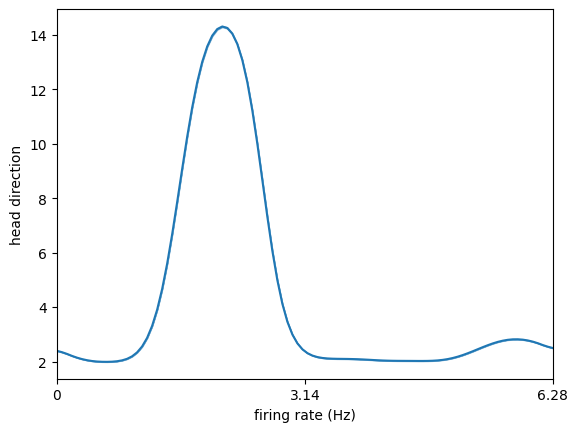

In [10]:
plot_tuning_curve(hd_rate, sweep, neuron=0, xlabel='firing rate (Hz)', ylabel='head direction')

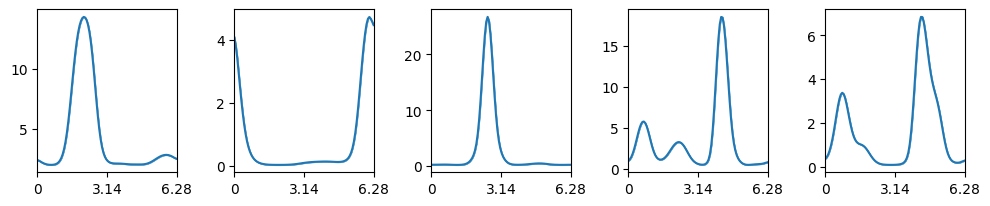

In [11]:
plt.figure(figsize=(10, 10))

for i in range(dataset_hdc['neurons']):
    ax = plt.subplot(5, 5, i+1)
    plot_tuning_curve(hd_rate, sweep, neuron=i, ax=ax)

plt.tight_layout()
plt.show()

## Tuning curves of non-HD neurons

In [12]:
neurons = list(range(dataset_nonhdc['neurons']))

hd_rate, hd_FF, sweep = tuning_curve_1d('hd', neurons, modelfit_nonhdc, rcov, model_dict_nonhdc['tbin'], batch_size=100)

99

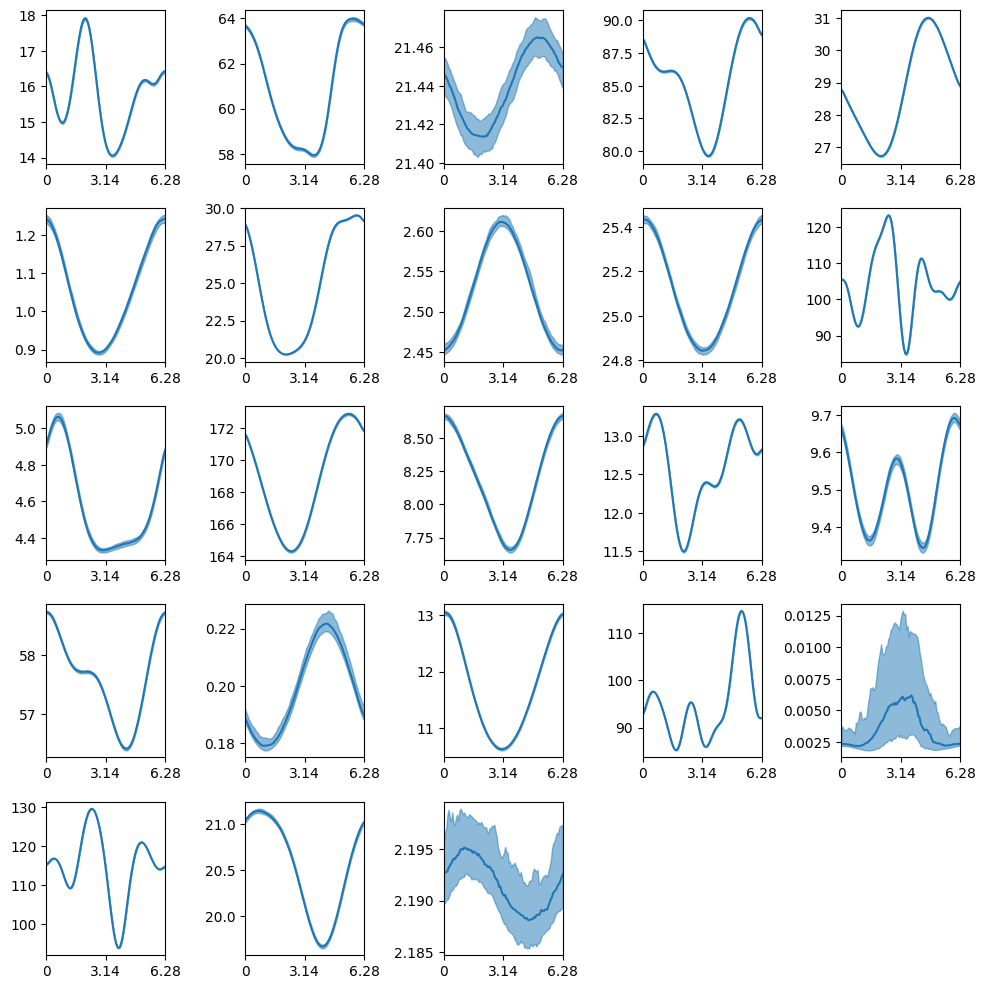

In [13]:
plt.figure(figsize=(10, 10))


for i in range(dataset_nonhdc['neurons']):
    ax = plt.subplot(5, 5, i+1)
    plot_tuning_curve(hd_rate, sweep, neuron=i, ax=ax)

plt.tight_layout()
plt.show()

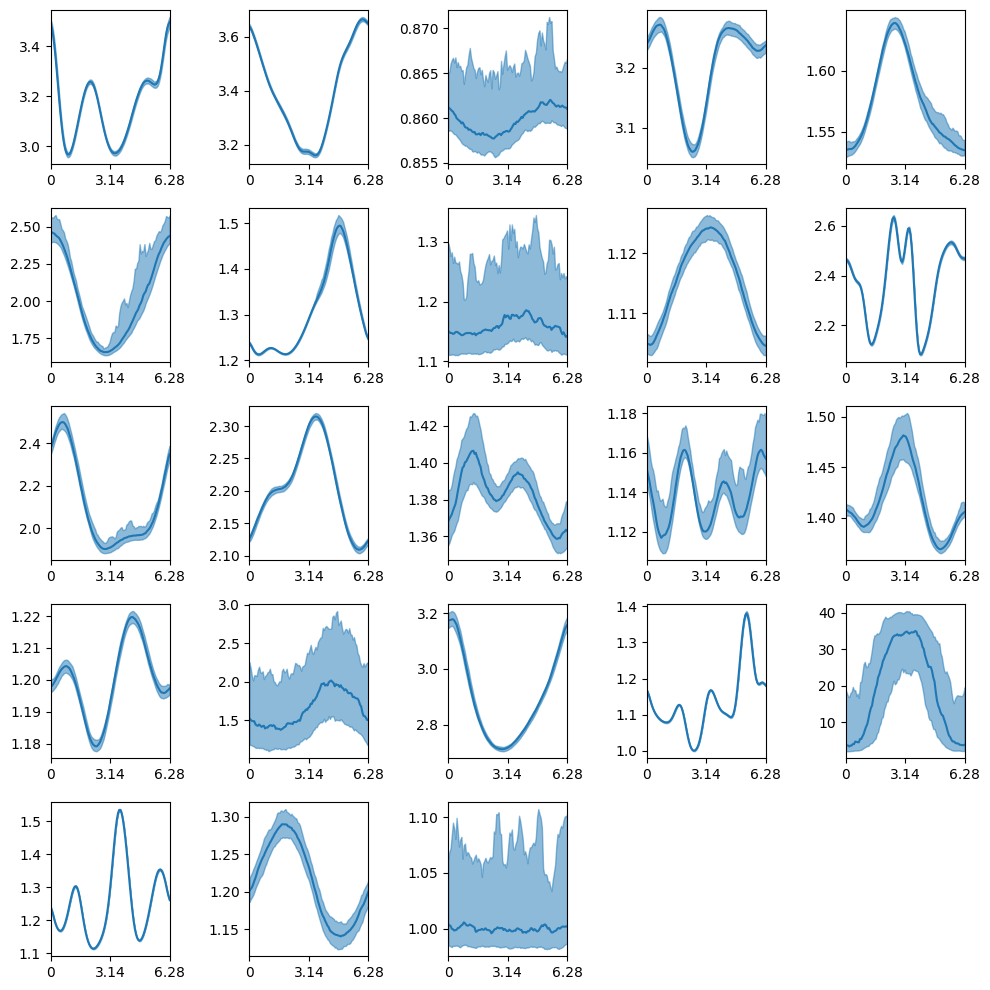

In [14]:
plt.figure(figsize=(10, 10))


for i in range(dataset_nonhdc['neurons']):
    ax = plt.subplot(5, 5, i+1)
    plot_tuning_curve(hd_FF, sweep, neuron=i, ax=ax)

plt.tight_layout()
plt.show()

## Computation of tuning curves as slices through multi-dimensional tuning curves (for comparison only)

In [24]:
hd_sweep = torch.linspace(0, 2 * np.pi, 100)
rcov = dataset_nonhdc['covariates']
covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean() * torch.ones((100, 1)) for k in rcov.keys()],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

P_list = []

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit_nonhdc, covariates, list(range(dataset_nonhdc['neurons'])), MC=30,
        trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

In [25]:
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

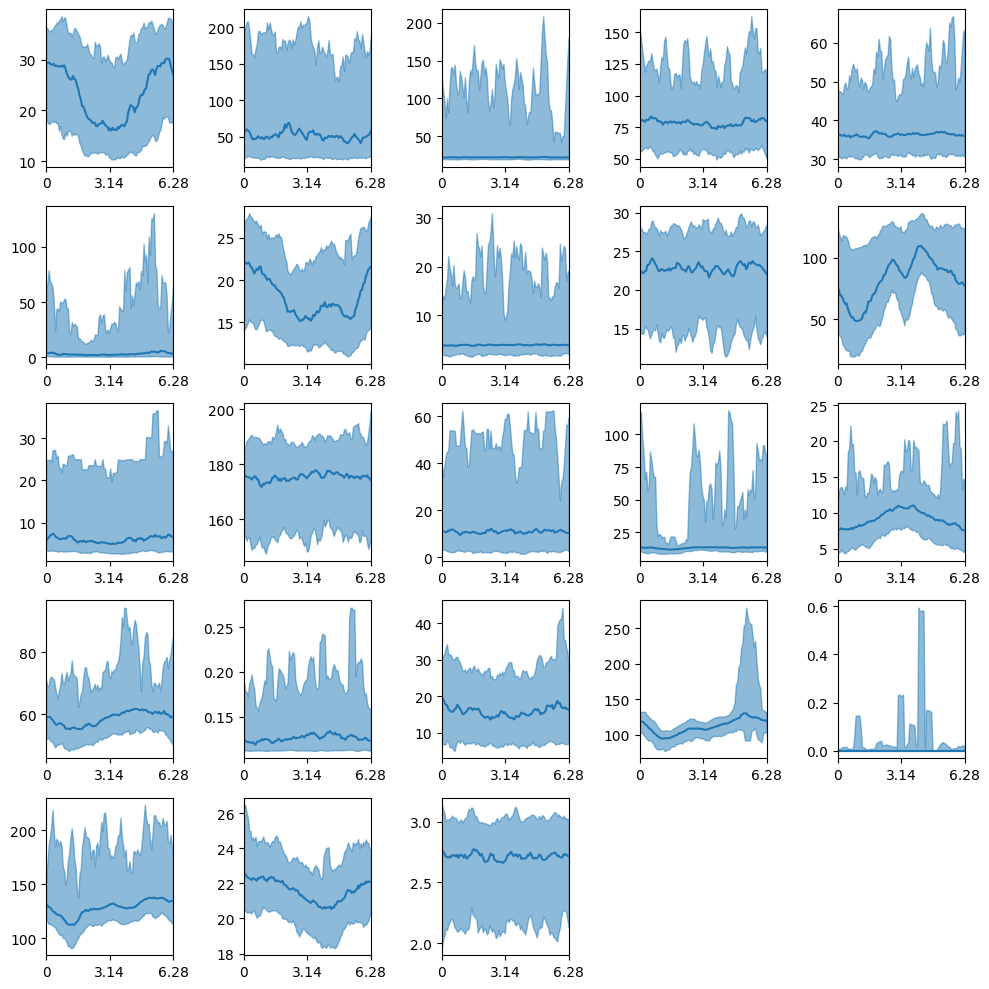

In [26]:
x_sweep = hd_sweep.numpy().flatten()

plt.figure(figsize=(10, 10))


for i in range(dataset_nonhdc['neurons']):
    ax = plt.subplot(5, 5, i+1)
    plot_tuning_curve(hd_rate, x_sweep, neuron=i, ax=ax)

plt.tight_layout()
plt.show()

## Tuning index computation

In [15]:
def tuning_index(hd_stat):

    _, tc_mean, _ = utils.signal.percentiles_from_samples(hd_stat, [0.05, 0.5, 0.95])

    tc_max, _ = torch.max(tc_mean, axis=1)
    tc_min, _ = torch.min(tc_mean, axis=1)

    return (tc_max - tc_min) / (tc_max + tc_min)

In [16]:
TI_rate = tuning_index(hd_rate)


print(TI_rate)

tensor([0.1207, 0.0497, 0.0012, 0.0619, 0.0744, 0.1647, 0.1864, 0.0314, 0.0118,
        0.1843, 0.0780, 0.0255, 0.0619, 0.0721, 0.0184, 0.0203, 0.1062, 0.1021,
        0.1479, 0.4797, 0.1595, 0.0359, 0.0016])


In [17]:
nonhdc_neurons = list(range(dataset_nonhdc['neurons']))
hdc_neurons = list(range(dataset_hdc['neurons']))

In [18]:
features = []
for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    print('Calculating tuning indices for ', cov, '\n')
    hd_rate, hd_FF, sweep = tuning_curve_1d(cov, nonhdc_neurons, modelfit_nonhdc, dataset_nonhdc['covariates'], 
                                            model_dict_nonhdc['tbin'], batch_size=100)
    TI_rate = tuning_index(hd_rate)
    features.append(TI_rate)

Calculating tuning indices for  hd
99Calculating tuning indices for  omega
99Calculating tuning indices for  speed
99Calculating tuning indices for  x
99Calculating tuning indices for  y
99Calculating tuning indices for  time
99

In [24]:
f = np.array([features[i].numpy() for i in range(len(features))])

features_nonhdc = np.swapaxes(f, 0, 1) # num_neurons x num_covariates

[tensor([0.1205, 0.0496, 0.0012, 0.0618, 0.0744, 0.1645, 0.1863, 0.0314, 0.0118,
        0.1843, 0.0777, 0.0255, 0.0616, 0.0722, 0.0184, 0.0203, 0.1074, 0.1016,
        0.1478, 0.5061, 0.1595, 0.0359, 0.0016]), tensor([7.6295e-02, 1.2467e-01, 2.2213e-02, 1.0784e-02, 7.6673e-02, 2.4715e-01,
        3.1098e-01, 5.2781e-02, 7.4625e-02, 4.7290e-02, 7.6956e-02, 9.9787e-02,
        5.7013e-04, 3.5675e-02, 5.4551e-03, 6.7685e-02, 9.2265e-01, 4.3747e-02,
        3.6714e-02, 9.6570e-01, 7.5797e-02, 5.7819e-02, 3.0742e-03]), tensor([0.2153, 0.1147, 0.0239, 0.2339, 0.3341, 0.0290, 0.2403, 0.5547, 0.0569,
        0.2690, 0.2478, 0.2365, 0.0193, 0.2756, 0.2384, 0.1275, 0.0132, 0.1681,
        0.1668, 0.7774, 0.1797, 0.2075, 0.2433]), tensor([0.1233, 0.1142, 0.0201, 0.0700, 0.0682, 0.3306, 0.0338, 0.2973, 0.0691,
        0.0612, 0.1341, 0.0308, 0.3778, 0.0513, 0.1134, 0.0106, 0.0186, 0.3306,
        0.0381, 0.3931, 0.0249, 0.0196, 0.0173]), tensor([0.1189, 0.0812, 0.0309, 0.0504, 0.0331, 0.4278, 0.0

In [25]:
features = []
for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    print('Calculating tuning indices for ', cov)
    hd_rate, hd_FF, sweep = tuning_curve_1d(cov, hdc_neurons, modelfit_hdc, dataset_hdc['covariates'], 
                                            model_dict_hdc['tbin'], batch_size=100)
    TI_rate = tuning_index(hd_rate)
    features.append(TI_rate)

Calculating tuning indices for  hd
99Calculating tuning indices for  omega
99Calculating tuning indices for  speed
99Calculating tuning indices for  x
99Calculating tuning indices for  y
99Calculating tuning indices for  time
99

In [27]:
f = np.array([features[i].numpy() for i in range(len(features))])


features_hdc = np.swapaxes(f, 0, 1) # num_neurons x num_covariates

In [31]:
print(features_hdc)
print(features_nonhdc)

[[0.75560087 0.20082067 0.27094135 0.11371452 0.09150316 0.1687342 ]
 [0.9866594  0.4032379  0.2992882  0.16382064 0.09068148 0.0931792 ]
 [0.9816935  0.3141905  0.21375637 0.10360593 0.03652094 0.09130458]
 [0.9510068  0.24246086 0.02159554 0.07362805 0.04249533 0.20418923]
 [0.9779315  0.51360637 0.01412963 0.07092871 0.02286066 0.09063332]]
[[1.20499827e-01 7.62947574e-02 2.15279862e-01 1.23253718e-01
  1.18920527e-01 2.13193789e-01]
 [4.96261343e-02 1.24670394e-01 1.14719689e-01 1.14180498e-01
  8.12202170e-02 3.36265229e-02]
 [1.21956773e-03 2.22131852e-02 2.38720421e-02 2.01324280e-02
  3.08652129e-02 1.93748586e-02]
 [6.17947690e-02 1.07838996e-02 2.33858809e-01 7.00073093e-02
  5.04349917e-02 1.22420162e-01]
 [7.44196698e-02 7.66727701e-02 3.34061712e-01 6.81547076e-02
  3.31080481e-02 4.90291044e-02]
 [1.64458409e-01 2.47148708e-01 2.89777201e-02 3.30557108e-01
  4.27773297e-01 2.72842348e-01]
 [1.86319202e-01 3.10979992e-01 2.40307719e-01 3.38223949e-02
  1.98288746e-02 1.685

In [34]:
features_combined = np.vstack((features_hdc, features_nonhdc))

<BarContainer object of 6 artists>

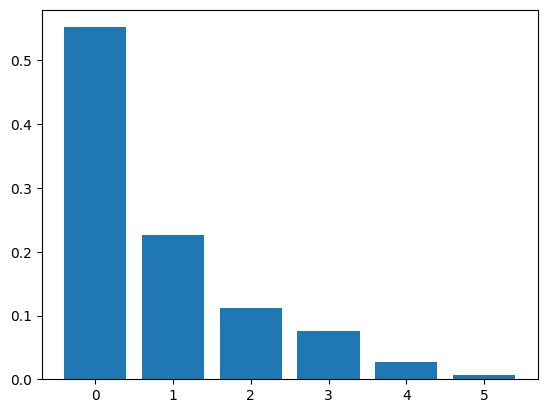

In [35]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(features_combined)
var_explained = pca.explained_variance_ratio_

plt.bar(np.arange(len(var_explained)), var_explained)

In [37]:
num_hdc_neurons = dataset_hdc['neurons']
num_total_neurons = dataset_nonhdc['neurons'] + num_hdc_neurons
num_nonhdc_neurons = dataset_nonhdc['neurons']
labels = [0]*num_hdc_neurons + [1]*num_nonhdc_neurons

components = pca.fit_transform(features_combined)

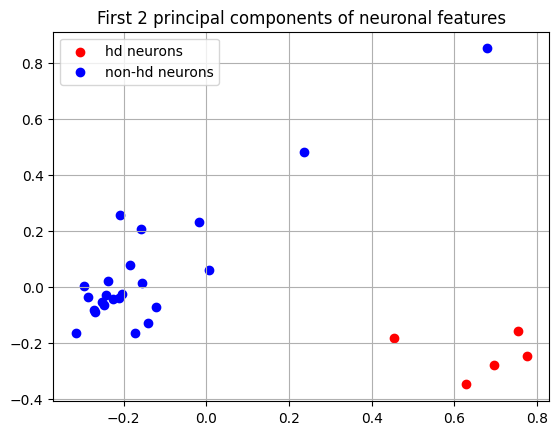

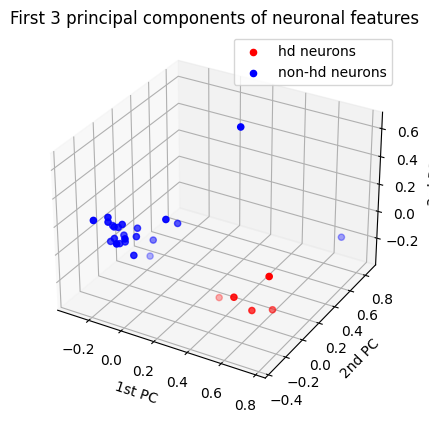

In [53]:
fig, ax = plt.subplots()
ax.scatter(components[:num_hdc_neurons, 0], components[:num_hdc_neurons, 1], label='hd neurons', c='r')
ax.scatter(components[num_hdc_neurons:, 0], components[num_hdc_neurons:, 1], label='non-hd neurons', c='b')
ax.set_title('First 2 principal components of neuronal features')
ax.legend()
ax.grid()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(components[:num_hdc_neurons, 0], components[:num_hdc_neurons, 1], components[:num_hdc_neurons, 2], 
           c='r', label='hd neurons')
ax.scatter(components[num_hdc_neurons:, 0], components[num_hdc_neurons:, 1], components[num_hdc_neurons:, 2], 
           c='b', label='non-hd neurons')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
ax.set_title('First 3 principal components of neuronal features')
ax.legend()